In [6]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import tensorflow as tf 
from tensorflow import keras 
from tensorflow.keras.losses import MeanSquaredError

In [7]:
df = pd.read_csv(r'F:\College\SEM 8\Project Phase 2\Dataset\NCA Preprocessed\master_features_nca.csv')
df

,filename,cell_id,temp,charge_rate,discharge_rate,cycle,SOH,IC_bin_1,IC_bin_2,IC_bin_3,...,IC_bin_11,IC_bin_12,IC_bin_13,IC_bin_14,IC_bin_15,IC_bin_16,IC_bin_17,IC_bin_18,IC_bin_19,IC_bin_20
0,CY25-025_1-#1.csv,1,25,0.25,1.0,1,99.96,3.206253,3.435524,3.772510,...,4.255246,4.207070,4.229390,4.248806,4.264151,4.198406,4.058616,3.920543,3.792856,3.647914
1,CY25-025_1-#1.csv,1,25,0.25,1.0,2,99.98,3.185611,3.409977,3.737496,...,4.249921,4.223132,4.181276,4.225006,4.231327,4.158785,4.055173,3.905594,3.737473,3.648392
2,CY25-025_1-#1.csv,1,25,0.25,1.0,3,100.00,3.166235,3.397673,3.713245,...,4.235653,4.189766,4.140167,4.167926,4.180849,4.145106,4.015124,3.896722,3.756668,3.646670
3,CY25-025_1-#1.csv,1,25,0.25,1.0,4,99.97,3.139468,3.376350,3.683448,...,4.254307,4.162355,4.134256,4.143371,4.135573,4.118733,4.023064,3.867330,3.752034,3.631178
4,CY25-025_1-#1.csv,1,25,0.25,1.0,5,99.93,3.132129,3.346752,3.653736,...,4.216513,4.164974,4.094929,4.101335,4.135343,4.100581,4.008745,3.881142,3.761407,3.626212
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22639,CY45-05_1-#9.csv,9,45,0.50,1.0,411,84.65,2.514883,2.565545,2.627766,...,3.248165,3.376864,3.545380,3.705835,3.774339,3.705556,3.564230,3.413748,3.287599,3.193869
22640,CY45-05_1-#9.csv,9,45,0.50,1.0,412,84.61,2.510205,2.560754,2.625429,...,3.250500,3.392370,3.559592,3.706725,3.763518,3.694866,3.559024,3.417873,3.299083,3.207045
22641,CY45-05_1-#9.csv,9,45,0.50,1.0,413,84.60,2.513525,2.562124,2.623266,...,3.245492,3.372555,3.540142,3.694258,3.752898,3.692722,3.562536,3.425323,3.303745,3.206924
22642,CY45-05_1-#9.csv,9,45,0.50,1.0,414,84.58,2.508238,2.557557,2.619624,...,3.241048,3.372799,3.540815,3.700767,3.761809,3.701606,3.569719,3.425509,3.299934,3.202914


In [ ]:
# -------------------------
# 0. ONE-HOT encode temp & charge-rate
# -------------------------
df_one_hot = pd.get_dummies(df, columns=['temp','charge_rate'])

# -------------------------
# 1. Drop unused columns
# -------------------------
df_dropped = df_one_hot.drop(columns=['filename', 'cell_id', 'discharge_rate'])

# -------------------------
# 2. Identify columns
# -------------------------
ic_cols = [col for col in df_dropped.columns if 'IC' in col]      # 20 IC bins
cycle_col = 'cycle'
one_hot_cols = [col for col in df_dropped.columns 
                if 'temp_' in col or 'charge_rate_' in col]

# Convert to arrays
X_ic_all = df_dropped[ic_cols].values               # (N,20)
X_cycle_all = df_dropped[[cycle_col]].values        # (N,1)
X_onehot_all = df_dropped[one_hot_cols].values      # (N,6)
Y = df_dropped['SOH'].values                        # (N,)

# ---------------------------------------------------
# 3. Remove NaN / INF first
# ---------------------------------------------------
mask_clean = (
    ~np.isnan(X_ic_all).any(axis=1) &
    ~np.isnan(X_cycle_all).any(axis=1) &
    ~np.isnan(X_onehot_all).any(axis=1) &
    ~np.isnan(Y) &
    ~np.isinf(X_ic_all).any(axis=1) &
    ~np.isinf(X_cycle_all).any(axis=1) &
    ~np.isinf(X_onehot_all).any(axis=1) &
    ~np.isinf(Y)
)

print("Rows removed due to NaN/Inf:", np.sum(~mask_clean))

X_ic_all     = X_ic_all[mask_clean]
X_cycle_all  = X_cycle_all[mask_clean]
X_onehot_all = X_onehot_all[mask_clean]
Y            = Y[mask_clean]


# ---------------------------------------------------
# 4. REMOVE IC OUTLIERS (YOUR RULE: IC < 0 OR IC > 20)
# ---------------------------------------------------
LOW_LIMIT  = 0
HIGH_LIMIT = 20

mask_outlier = np.all(
    (X_ic_all >= LOW_LIMIT) & (X_ic_all <= HIGH_LIMIT),
    axis=1
)

print("Rows removed due to IC outliers:", np.sum(~mask_outlier))

# Apply mask everywhere
X_ic_all     = X_ic_all[mask_outlier]
X_cycle_all  = X_cycle_all[mask_outlier]
X_onehot_all = X_onehot_all[mask_outlier]
Y            = Y[mask_outlier]


# -------------------------
# 5. Train-test split
# -------------------------
X_ic_train, X_ic_test, \
X_cycle_train, X_cycle_test, \
X_onehot_train, X_onehot_test, \
y_train, y_test = train_test_split(
    X_ic_all, X_cycle_all, X_onehot_all, Y,
    train_size=0.8, random_state=42
)

# -------------------------
# 6. Standardize IC bins
# -------------------------
ic_scaler = StandardScaler()
X_ic_train = ic_scaler.fit_transform(X_ic_train)
X_ic_test = ic_scaler.transform(X_ic_test)

# -------------------------
# 7. Standardize cycle number
# -------------------------
cycle_scaler = StandardScaler()
X_cycle_train = cycle_scaler.fit_transform(X_cycle_train)
X_cycle_test = cycle_scaler.transform(X_cycle_test)

# -------------------------
# 8. Build context vector = cycle + one-hot
# -------------------------
X_context_train = np.concatenate([X_cycle_train, X_onehot_train], axis=1)
X_context_test = np.concatenate([X_cycle_test, X_onehot_test], axis=1)

# -------------------------
# 9. Normalize SOH target
# -------------------------
y_mean = y_train.mean()
y_std = y_train.std()

y_train = (y_train - y_mean) / y_std
y_test  = (y_test - y_mean) / y_std

# -------------------------
# 10. Expand dims for CNN/LSTM input
# -------------------------
X_ic_train = np.expand_dims(X_ic_train, axis=2)  
X_ic_test  = np.expand_dims(X_ic_test, axis=2)

# -------------------------
# 11. Print final shapes & ranges
# -------------------------
print("Final IC range:", X_ic_test.min(), X_ic_test.max())
print("IC:", X_ic_train.shape)
print("Context:", X_context_train.shape)
print("Y:", y_train.shape)


Rows removed due to NaN/Inf: 3
Rows removed due to IC outliers: 4
Final IC range: -8.413057359147434 11.611967272321516
IC: (18109, 20, 1)
Context: (18109, 7)
Y: (18109,)


In [9]:
adv_fgsm_cnn = keras.models.load_model(r"F:\College\SEM 8\Project Phase 2\Adversarial Training\fgsm_trained_cnn.keras")
adv_jsma_lstm = keras.models.load_model(r"F:\College\SEM 8\Project Phase 2\Adversarial Training\jsma_trained_cnn_lstm.keras")
adv_cw_gru = keras.models.load_model(r"F:\College\SEM 8\Project Phase 2\Adversarial Training\c&w_trained_cnn_gru.keras")
adv_pgd_rcn = keras.models.load_model(r"F:\College\SEM 8\Project Phase 2\Adversarial Training\pgd_trained_rcn.keras")

base_cnn_gru = keras.models.load_model(r"F:\College\SEM 8\Project Phase 2\Models\best_cnn_gru_1.keras")

In [10]:
fgsm_cnn_pred = adv_fgsm_cnn.predict([X_ic_test, X_context_test])
jsma_lstm_pred = adv_jsma_lstm.predict([X_ic_test, X_context_test])
cw_gru_pred = adv_cw_gru.predict([X_ic_test, X_context_test])
pgd_rcn_pred = adv_pgd_rcn.predict([X_ic_test,X_context_test])

base_gru_pred = base_cnn_gru.predict([X_ic_test, X_context_test])


142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


In [11]:
predictions = np.column_stack((fgsm_cnn_pred, jsma_lstm_pred, cw_gru_pred, pgd_rcn_pred, base_gru_pred))

In [12]:
print(predictions.shape)

(4528, 5)


In [13]:
from sklearn.metrics import mean_squared_error

mse_fgsm = mean_squared_error(y_test, fgsm_cnn_pred)
mse_jsma = mean_squared_error(y_test, jsma_lstm_pred)
mse_cw   = mean_squared_error(y_test, cw_gru_pred)
mse_pgd  = mean_squared_error(y_test, pgd_rcn_pred)
mse_base = mean_squared_error(y_test, base_gru_pred)

print("FGSM MSE:", mse_fgsm)
print("JSMA MSE:", mse_jsma)
print("CW MSE:", mse_cw)
print("PGD MSE:", mse_pgd)
print("BASE MSE:", mse_base)


FGSM MSE: 0.02772129310830433
JSMA MSE: 0.00456078483537706
CW MSE: 0.004764119880823274
PGD MSE: 0.007009469967391701
BASE MSE: 0.0027404128015763147


In [14]:
print("MSEs:", mse_fgsm, mse_jsma, mse_cw, mse_pgd, mse_base)

weights = np.array([
    1/mse_fgsm,
    1/mse_jsma,
    1/mse_cw,
    1/mse_pgd,
    1/mse_base
], dtype=float)

weights = weights / np.sum(weights)
print("Normalized Weights:", weights)

final_pred = np.sum(predictions * weights, axis=1)

mse_ens = mean_squared_error(y_test, final_pred)
mae_ens = mean_absolute_error(y_test, final_pred)
r2_ens  = r2_score(y_test, final_pred)

print("\n===== Ensemble Performance =====")
print("MSE:", mse_ens)
print("MAE:", mae_ens)
print("R² :", r2_ens)

MSEs: 0.02772129310830433 0.00456078483537706 0.004764119880823274 0.007009469967391701 0.0027404128015763147
Normalized Weights: [0.03708164 0.22538909 0.21576937 0.14665176 0.37510814]

===== Ensemble Performance =====
MSE: 0.003300369193989689
MAE: 0.04044301323491839
R² : 0.9967086607110934


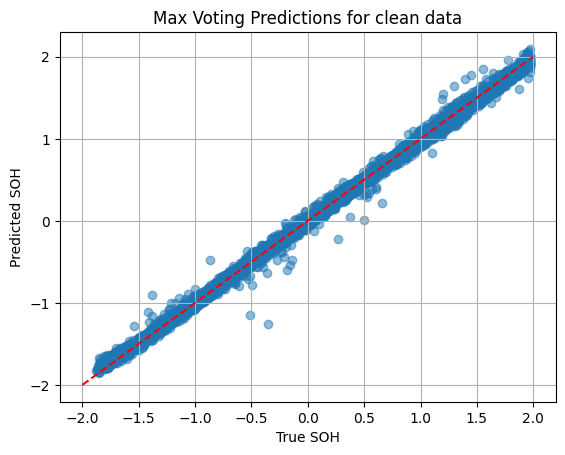

In [15]:
import matplotlib.pyplot as plt 

plt.scatter(y_test, final_pred, alpha = 0.5)
plt.plot([-2,2],[-2,2],"r--")
plt.title("Max Voting Predictions for clean data")
plt.xlabel("True SOH")
plt.ylabel("Predicted SOH")
plt.grid()
plt.show()

In [16]:
def fgsm_attack(model, X_ic_test, X_context_test, y_test, epsilon = 0.05):
    X_ic_adv = tf.convert_to_tensor(X_ic_test)
    X_context_test = tf.convert_to_tensor(X_context_test)
    y_true = tf.convert_to_tensor(y_test)
    
    with tf.GradientTape() as tape:
        tape.watch(X_ic_adv)
        y_pred = model([X_ic_adv, X_context_test],training=False)
        loss = tf.keras.losses.MeanSquaredError()(y_true, y_pred)

    gradient = tape.gradient(loss, X_ic_adv)
    signed_grad = tf.sign(gradient)
    X_ic_adv = X_ic_adv + epsilon * signed_grad

    return X_ic_adv.numpy()

In [17]:
def pgd_attack(model, X_ic_test, X_context_test, y_test, alpha = 0.01, epsilon = 0.05, num_iterations = 10):
    X_ic_adv = tf.convert_to_tensor(X_ic_test)
    X_context_test = tf.convert_to_tensor(X_context_test)
    y_true = tf.convert_to_tensor(y_test)
    
    for _ in range(num_iterations):
        with tf.GradientTape() as Tape:
            Tape.watch(X_ic_adv)
            y_pred = model([X_ic_adv, X_context_test], training=False)
            loss = tf.keras.losses.MeanSquaredError()(y_true, y_pred)
        gradient = Tape.gradient(loss, X_ic_adv)
        signed_grad = tf.sign(gradient)
        X_ic_adv = X_ic_adv + alpha * signed_grad
        X_ic_adv = tf.clip_by_value(X_ic_adv, X_ic_test - epsilon, X_ic_test + epsilon)
    
    return X_ic_adv.numpy()

In [18]:
def jsma_attack(model, X_ic_test, X_context_test, y_test, epsilon=0.7, k=3):

    X_ic_np = np.array(X_ic_test, dtype=np.float32)
    X_context_np = np.array(X_context_test, dtype=np.float32)
    y_np = np.array(y_test, dtype=np.float32)

    X_ic_adv = X_ic_np.copy()

    for i in range(X_ic_np.shape[0]):
        
        x_var = tf.Variable(X_ic_np[i:i+1], dtype=tf.float32)
        context_sample = tf.convert_to_tensor(X_context_np[i:i+1], dtype=tf.float32)
        y_true = tf.convert_to_tensor(y_np[i:i+1], dtype=tf.float32)

        with tf.GradientTape() as tape:
            tape.watch(x_var)
            y_pred = model([x_var, context_sample], training=False)
            loss = tf.reduce_mean(tf.keras.losses.MSE(y_true, y_pred))

        gradient = tape.gradient(loss, x_var)
        if gradient is None:
            # Skip this sample if gradient couldn't be computed
            continue

        # Convert gradient to 1D numpy array aligned with timesteps
        grad_np = gradient.numpy().reshape(-1)

        # Saliency = absolute gradient magnitude per timestep
        saliency = np.abs(grad_np)
        
        # Pick top-k timesteps to perturb
        indices = np.argsort(saliency)[-k:]

        for idx in indices:
            # idx indexes the flattened timestep dimension; for shape (1, T, 1) flatten -> T
            X_ic_adv[i, idx, 0] += epsilon * np.sign(grad_np[idx])

    X_ic_adv = np.clip(X_ic_adv, -3.0, 3.0)

    return X_ic_adv

In [19]:
def candw_attack(model, X_ic_test, X_context_test, y_test, attack_weight = 1.0 , lr = 0.01, steps = 100, clip_min = -5.0, clip_max = 7.0):
    X_ic_test = tf.convert_to_tensor(X_ic_test, dtype= tf.float32)
    X_context_test = tf.convert_to_tensor(X_context_test, dtype= tf.float32)
    y_test = tf.convert_to_tensor(y_test, dtype= tf.float32)
    y_test = tf.expand_dims(y_test, axis = -1)

    delta = tf.Variable(tf.zeros_like(X_ic_test), trainable=True)

    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

    for _ in range(steps):
        with tf.GradientTape() as Tape:
            X_ic_adv = X_ic_test + delta
            X_ic_adv = tf.clip_by_value(X_ic_adv, clip_min, clip_max)

            y_pred = model([X_ic_adv, X_context_test], training=False)

            mse = tf.reduce_mean(tf.keras.losses.MSE(y_test, y_pred))

            l2 = tf.reduce_mean(tf.reduce_sum(tf.square(delta), axis =[1,2]))

            loss = l2 - attack_weight * mse
        
        gradient = Tape.gradient(loss, delta)
        optimizer.apply_gradients([(gradient,delta)])

    X_ic_adv = tf.clip_by_value(X_ic_adv + delta, clip_min, clip_max)

    return X_ic_adv.numpy()


__Clean Learners__

In [20]:
base_cnn = keras.models.load_model(r"F:\College\SEM 8\Project Phase 2\Models\best_cnn.keras")
base_lstm = keras.models.load_model(r"F:\College\SEM 8\Project Phase 2\Models\best_cnn_lstm_1.keras")
base_rcn = keras.models.load_model(r"F:\College\SEM 8\Project Phase 2\Models\best_rcn.keras")

In [22]:
X_ic_adv_fgsm_cnn = fgsm_attack(base_cnn, X_ic_test, X_context_test, y_test, epsilon=0.05)
X_ic_adv_jsma_lstm = jsma_attack(base_lstm, X_ic_test, X_context_test, y_test, epsilon=0.7, k=3)
X_ic_adv_cw_gru = candw_attack(base_cnn_gru, X_ic_test, X_context_test, y_test)
X_ic_adv_pgd_rcn = pgd_attack(base_rcn, X_ic_test, X_context_test, y_test)

In [35]:
def ensemble_eval(y_test,fgsm_cnn_pred, jsma_lstm_pred, cw_gru_pred, pgd_rcn_pred, base_gru_pred, title=""):

    mse_fgsm = mean_squared_error(y_test, fgsm_cnn_pred)
    mse_jsma = mean_squared_error(y_test, jsma_lstm_pred)
    mse_cw   = mean_squared_error(y_test, cw_gru_pred)
    mse_pgd  = mean_squared_error(y_test, pgd_rcn_pred)
    mse_base = mean_squared_error(y_test, base_gru_pred)

    print("FGSM CNN MSE:", mse_fgsm)
    print("JSMA LSTM MSE:", mse_jsma)
    print("CW GRU MSE:", mse_cw)
    print("PGD RCN MSE:", mse_pgd)
    print("BASE MSE:", mse_base)

    predictions = np.column_stack((fgsm_cnn_pred, jsma_lstm_pred, cw_gru_pred, pgd_rcn_pred, base_gru_pred))

    weights = np.array([
        1/mse_fgsm,
        1/mse_jsma,
        1/mse_cw,
        1/mse_pgd,
        1/mse_base
    ], dtype=float)

    weights = weights / np.sum(weights)
    print("Normalized Weights:", weights)

    final_pred = np.sum(predictions * weights, axis=1)

    mse_ens = mean_squared_error(y_test, final_pred)
    mae_ens = mean_absolute_error(y_test, final_pred)
    r2_ens  = r2_score(y_test, final_pred)

    print("\n===== Ensemble Performance " + title + " attacked Data=====")
    print("MSE:", mse_ens)
    print("MAE:", mae_ens)
    print("R² :", r2_ens)

    plt.scatter(y_test, final_pred, alpha = 0.5)
    plt.plot([-2,2],[-2,2],"r--")
    plt.title(title+" attacked data max voting predictions")
    plt.xlabel("True SOH")
    plt.ylabel("Predicted SOH")
    plt.grid()
    plt.show()   


142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
FGSM CNN MSE: 0.025786174892905064
JSMA LSTM MSE: 0.005024057337640976
CW GRU MSE: 0.005220539867017319
PGD RCN MSE: 0.007305077620599996
BASE MSE: 0.003342062393538617
Normalized Weights: [0.04480798 0.22997874 0.22132316 0.15816757 0.34572256]

===== Ensemble Performance FGSM attacked Data=====
MSE: 0.0037080176957609923
MAE: 0.04311179356123474
R² : 0.996302127547353


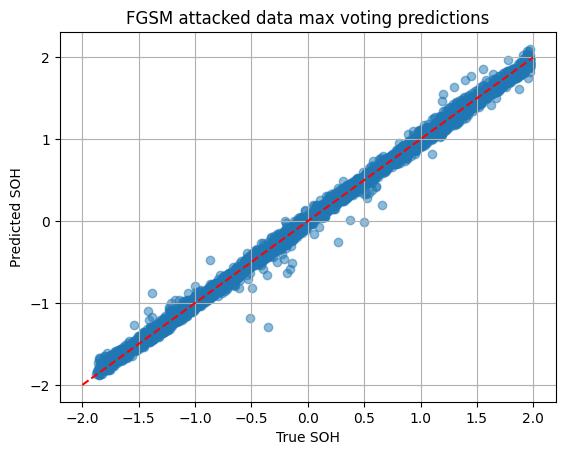

In [36]:
fgsm_cnn_pred = adv_fgsm_cnn.predict([X_ic_adv_fgsm_cnn, X_context_test])
jsma_lstm_pred = adv_jsma_lstm.predict([X_ic_adv_fgsm_cnn, X_context_test])
cw_gru_pred = adv_cw_gru.predict([X_ic_adv_fgsm_cnn, X_context_test])
pgd_rcn_pred = adv_pgd_rcn.predict([X_ic_adv_fgsm_cnn,X_context_test])

base_gru_pred = base_cnn_gru.predict([X_ic_adv_fgsm_cnn, X_context_test])

ensemble_eval(y_test, fgsm_cnn_pred, jsma_lstm_pred, cw_gru_pred, pgd_rcn_pred, base_gru_pred, title="FGSM")


142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
FGSM CNN MSE: 0.09165830342004387
JSMA LSTM MSE: 0.0742592275762493
CW GRU MSE: 0.08597191328366313
PGD RCN MSE: 0.016969089613084194
BASE MSE: 0.06494910517767562
Normalized Weights: [0.09888103 0.12204904 0.10542126 0.53410452 0.13954415]

===== Ensemble Performance JSMA attacked Data=====
MSE: 0.028787033348395767
MAE: 0.1399536804815397
R² : 0.9712917288031941


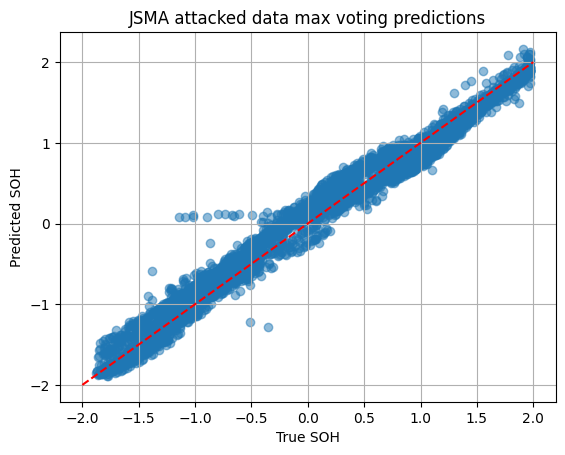

In [38]:
fgsm_cnn_pred = adv_fgsm_cnn.predict([X_ic_adv_jsma_lstm, X_context_test])
jsma_lstm_pred = adv_jsma_lstm.predict([X_ic_adv_jsma_lstm, X_context_test])
cw_gru_pred = adv_cw_gru.predict([X_ic_adv_jsma_lstm, X_context_test])
pgd_rcn_pred = adv_pgd_rcn.predict([X_ic_adv_jsma_lstm,X_context_test])

base_gru_pred = base_cnn_gru.predict([X_ic_adv_jsma_lstm, X_context_test])

ensemble_eval(y_test, fgsm_cnn_pred, jsma_lstm_pred, cw_gru_pred, pgd_rcn_pred, base_gru_pred, title="JSMA")

142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
FGSM CNN MSE: 0.028041638056909433
JSMA LSTM MSE: 0.005181788057924895
CW GRU MSE: 0.005421663990204399
PGD RCN MSE: 0.008142483232533833
BASE MSE: 0.00367523107182246
Normalized Weights: [0.04413552 0.2388427  0.22827536 0.15199691 0.33674951]

===== Ensemble Performance PGD attacked Data=====
MSE: 0.0040703661424213895
MAE: 0.04584926044818382
R² : 0.9959407704964693


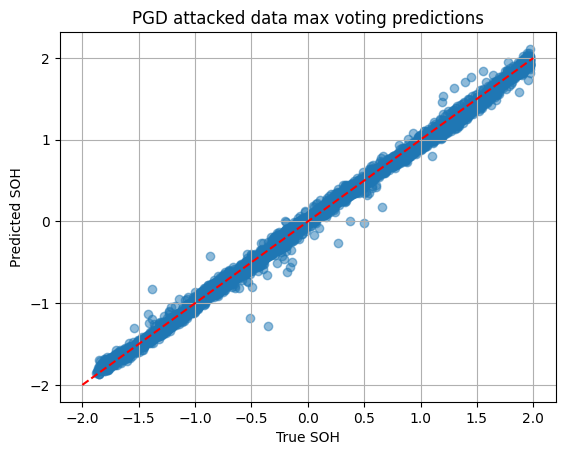

In [40]:
fgsm_cnn_pred = adv_fgsm_cnn.predict([X_ic_adv_pgd_rcn, X_context_test])
jsma_lstm_pred = adv_jsma_lstm.predict([X_ic_adv_pgd_rcn, X_context_test])
cw_gru_pred = adv_cw_gru.predict([X_ic_adv_pgd_rcn, X_context_test])
pgd_rcn_pred = adv_pgd_rcn.predict([X_ic_adv_pgd_rcn,X_context_test])

base_gru_pred = base_cnn_gru.predict([X_ic_adv_pgd_rcn, X_context_test])

ensemble_eval(y_test, fgsm_cnn_pred, jsma_lstm_pred, cw_gru_pred, pgd_rcn_pred, base_gru_pred, title="PGD")

142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
FGSM CNN MSE: 0.02804524780289696
JSMA LSTM MSE: 0.007266878272668479
CW GRU MSE: 0.007782725206101654
PGD RCN MSE: 0.0060235895051870296
BASE MSE: 0.007284281444133131
Normalized Weights: [0.05893148 0.22743577 0.21236109 0.27437926 0.22689239]

===== Ensemble Performance C&W attacked Data=====
MSE: 0.005594389243861465
MAE: 0.052089599476073646
R² : 0.9944209171660886


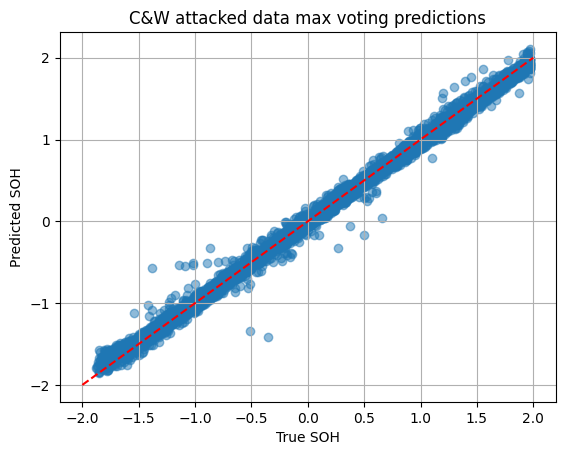

In [41]:
fgsm_cnn_pred = adv_fgsm_cnn.predict([X_ic_adv_cw_gru, X_context_test])
jsma_lstm_pred = adv_jsma_lstm.predict([X_ic_adv_cw_gru, X_context_test])
cw_gru_pred = adv_cw_gru.predict([X_ic_adv_cw_gru, X_context_test])
pgd_rcn_pred = adv_pgd_rcn.predict([X_ic_adv_cw_gru,X_context_test])

base_gru_pred = base_cnn_gru.predict([X_ic_adv_cw_gru, X_context_test])

ensemble_eval(y_test, fgsm_cnn_pred, jsma_lstm_pred, cw_gru_pred, pgd_rcn_pred, base_gru_pred, title="C&W")